<img style="float: right;" src="meetup_logo.svg" width=150>

# Meetup - Classification Models (2018)


<i>Predicting RSVP count using classification models</i>

<u>Models:</u>
1. <a href='#baseline'>Baseline</a> (dummy classifier)
2. <a href='#dtree'>Decision Tree</a>
3. <a href='#rf'>Random Forest</a>
4. <a href ='#boost'>XGBoost</a> 
5. <a href='#svc'>Penalized Support Vector Classifier</a> 
6. <a href='#stacked'>Aggregated Model</a>

***

## 0. Import libraries & data

In [1]:
# standard analysis packages
import pandas as pd
import numpy as np

# data preprocessor
from sklearn.preprocessing import StandardScaler

# modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import label_binarize, normalize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, auc

# xgb model
from xgboost import XGBClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# visualizations
import scikitplot as skplt # for roc-auc graph
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# to address class imbalance
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours as ENN

# misc
import pickle
from math import sqrt
import itertools
import warnings
import time
import datetime
warnings.filterwarnings('ignore')

# import helper functions
from classification_helpers import bin_yesrsvp, plot_feature_importances, show_conf_matrix, graph_roc, run_model

<a id='dtree'></a>
## 0. Data Exploration

In [2]:
# import dataset
df = pd.read_pickle('df_2018_cleaned.pickle')
df.head()

,event_created,event_description,event_duration,event_url,fee,group,event_headcount,how_to_find_us,event_id,maybe_rsvp_count,...,group_state,group_status,group_urlname,group_visibility,group_who,group_category,group_organizer_id,group_yrs_est,group_created_date,num_past_events
0,1535391367000,Join us in person or tune in online! Livestrea...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to second floor/ stream online at ...,254149786,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,236
1,1535385547000,Get started now on challenges related to these...,150.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,https://zoom.us/j/417883916,254146381,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,236
2,1535392484000,In this workshop we’ll get a clear sense of th...,150.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to second floor / Livestream at ht...,254150230,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,236
3,1531947994000,The number of opportunities for software engin...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to the 2nd floor,252915161,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,236
4,1535383458000,Please tune into the stream here: https://zoom...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please tune into the stream here: https://zoom...,254144933,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,236


Text(0.5, 1.0, 'Before removing outliers')

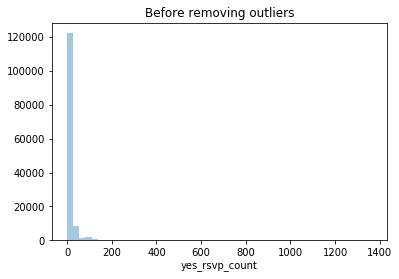

In [3]:
sns.distplot(df['yes_rsvp_count'], kde=False)
plt.title("Before removing outliers")

In [4]:
# remove outliers
df = df[(df['yes_rsvp_count']<=200) & (df['yes_rsvp_count'] != 0)]
df.reset_index(inplace=True)
df.shape

(134060, 58)

In [5]:
df.yes_rsvp_count.describe()

count    134060.000000
mean         12.934030
std          20.164287
min           1.000000
25%           1.000000
50%           5.000000
75%          21.000000
max         200.000000
Name: yes_rsvp_count, dtype: float64

Text(0.5, 1.0, 'After removing outliers')

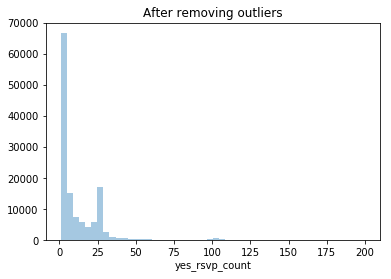

In [6]:
sns.distplot(df['yes_rsvp_count'], kde=False)
plt.title("After removing outliers")

### Bin `yes_rsvp_count` into categories

In [7]:
# calling helper function to apply custom binnng
df['yes_rsvp_count_class'] = df.apply(bin_yesrsvp, axis=1)

In [8]:
df[['yes_rsvp_count_class', 'yes_rsvp_count']].head()

,yes_rsvp_count_class,yes_rsvp_count
0,41-70,42
1,41-70,64
2,71-100,83
3,101-200,113
4,21-40,21


In [9]:
df['yes_rsvp_count_class'].value_counts()

1-10       86293
21-40      27637
11-20      13487
41-70       3016
101-200     2104
71-100      1523
Name: yes_rsvp_count_class, dtype: int64

In [11]:
list(set(df['yes_rsvp_count_class'].values.tolist()))

['101-200', '71-100', '41-70', '11-20', '1-10', '21-40']

In [12]:
class_num_dict_ = {"1-10" :1 ,
                   "11-20": 2,
                   "21-40": 3,
                   "41-70": 4,
                   "71-100": 5,
                   "101-200": 6}

In [13]:
df['yes_rsvp_count_class_num'] = df['yes_rsvp_count_class'].apply(lambda x: class_num_dict_.get(x))

In [14]:
df['yes_rsvp_count_class_num'].value_counts()

1    86293
3    27637
2    13487
4     3016
6     2104
5     1523
Name: yes_rsvp_count_class_num, dtype: int64

Text(0.5, 1.0, 'Count by Class Number')

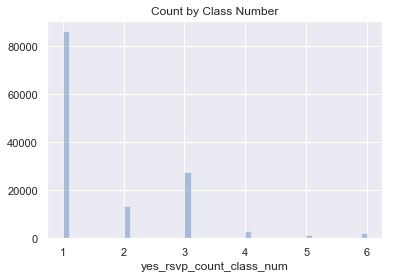

In [88]:
sns.distplot(df['yes_rsvp_count_class_num'], kde=False)
plt.title('Count by Class Number')

In [16]:
X = df[['event_duration','event_num_words','num_close_subways','num_members','group_yrs_est','num_past_events',
       'created_to_event_days','group_is_open', 'has_rsvp_limit', 'has_photo','has_event_fee', 
       'day_of_week','event_hour_group', 'group_category']]
y = df['yes_rsvp_count_class_num']

In [17]:
X.head()

,event_duration,event_num_words,num_close_subways,num_members,group_yrs_est,num_past_events,created_to_event_days,group_is_open,has_rsvp_limit,has_photo,has_event_fee,day_of_week,event_hour_group,group_category
0,120.0,137,12,8050,2.276969,236,8.204086,1,0,0,0,Tuesday,"[21, 24)",tech
1,150.0,131,9,8050,2.276969,236,9.333947,1,0,0,0,Thursday,"[0, 4)",tech
2,150.0,204,12,8050,2.276969,236,10.191157,1,0,0,0,Thursday,"[21, 24)",tech
3,120.0,229,12,8050,2.276969,236,51.057940,1,0,0,0,Friday,"[21, 24)",tech
4,120.0,165,9,8050,2.276969,236,14.420625,1,0,0,0,Tuesday,"[0, 4)",tech


In [18]:
dummies = pd.get_dummies(X.iloc[:,-3:], drop_first=True)

In [19]:
dummies.head()

,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,"event_hour_group_[4, 8)","event_hour_group_[8, 12)","event_hour_group_[12, 16)","event_hour_group_[16, 21)",...,group_category_pets-animals,group_category_photography,group_category_religion-beliefs,group_category_sci-fi-fantasy,group_category_singles,group_category_socializing,group_category_sports-recreation,group_category_support,group_category_tech,group_category_writing
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
X = pd.concat([X[['event_duration','event_num_words','num_close_subways','num_members','group_yrs_est','num_past_events',
       'created_to_event_days','group_is_open', 'has_rsvp_limit', 'has_photo','has_event_fee']], dummies], axis=1)

In [21]:
len(X.columns)

54

In [22]:
y.value_counts()

1    86293
3    27637
2    13487
4     3016
6     2104
5     1523
Name: yes_rsvp_count_class_num, dtype: int64

In [23]:
# pickle final X and y frames
with open('X_classification_v3.pickle', 'wb') as f:
    pickle.dump(X, f)
    
with open('y_classification_v3.pickle', 'wb') as f:
    pickle.dump(y, f)

In [37]:
# load final X and y frames
with open('X_classification_v3.pickle', 'rb') as f:
    X = pickle.load(f)
    
with open('y_classification_v3.pickle', 'rb') as f:
    y = pickle.load(f)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(normalize(X), y, test_size = 0.2, random_state=100)

In [39]:
print(X_train.shape)
print(X_test.shape)

(107248, 54)
(26812, 54)


<a id='baseline'></a>

### 1. Dummy Classifier (baseline)

In [27]:
baseline = DummyClassifier(random_state=100)
baseline.fit(X_train, y_train)
baseline_preds = baseline.predict(y_test)

print('\nClassification Report')
print('----------------------')
print(classification_report(y_test, baseline_preds))


Classification Report
----------------------
              precision    recall  f1-score   support

           1       0.64      0.65      0.65     17169
           2       0.09      0.09      0.09      2776
           3       0.20      0.20      0.20      5557
           4       0.03      0.02      0.03       604
           5       0.01      0.01      0.01       305
           6       0.00      0.00      0.00       401

   micro avg       0.47      0.47      0.47     26812
   macro avg       0.16      0.16      0.16     26812
weighted avg       0.46      0.47      0.47     26812



In [28]:
print('Accuracy: ', accuracy_score(y_test, baseline_preds))
print('F1 Score: ', f1_score(y_test, baseline_preds, average='weighted'))
print('Precision Score:', precision_score(y_test, baseline_preds, average='weighted'))
print('Recall Score:', recall_score(y_test, baseline_preds, average='weighted'))

Accuracy:  0.4681485901834999
F1 Score:  0.4664209002395167
Precision Score: 0.46474150723479757
Recall Score: 0.4681485901834999


### 2. Decision Tree

In [29]:
# model
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth = 5)


Classification Report
----------------------
              precision    recall  f1-score   support

           1       0.74      0.92      0.82     17169
           2       0.51      0.10      0.16      2776
           3       0.64      0.59      0.62      5557
           4       0.00      0.00      0.00       604
           5       0.00      0.00      0.00       305
           6       0.00      0.00      0.00       401

   micro avg       0.72      0.72      0.72     26812
   macro avg       0.32      0.27      0.27     26812
weighted avg       0.66      0.72      0.67     26812



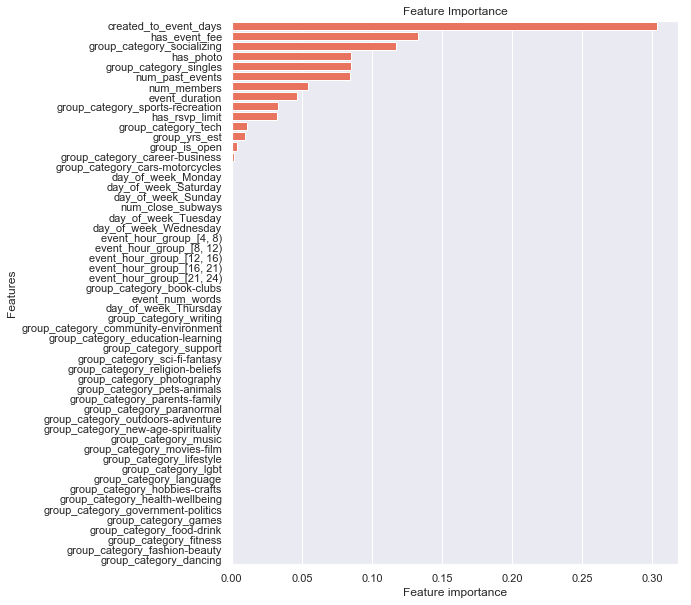

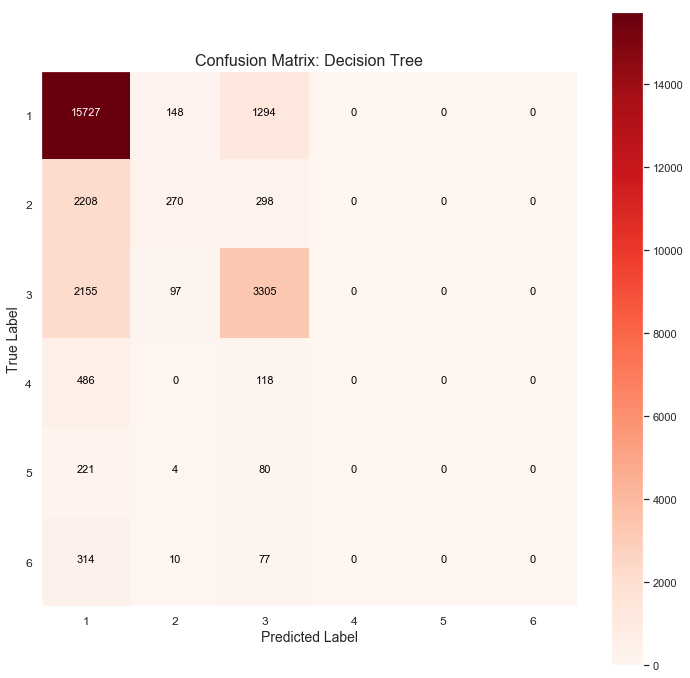

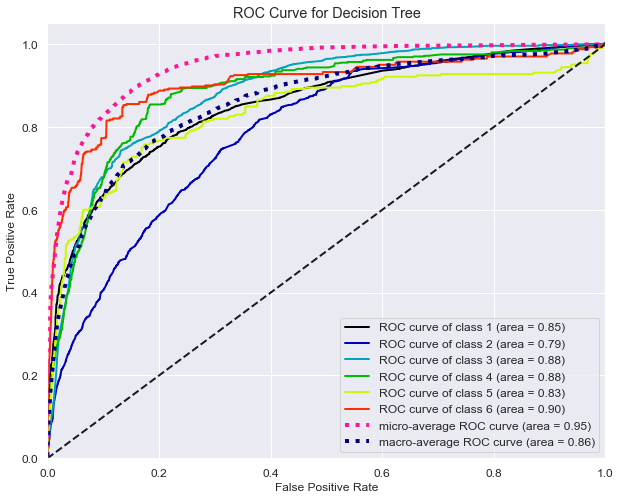

In [30]:
# build and run the model
run_model(tree_clf,
          pd.DataFrame(X_train, columns=X.columns),
          X_test,
          y_train,
          y_test,
          model_name="Decision Tree")

<a id='rf'></a>
## 3. Random Forest (w/ SMOTE-ENN)

Here we'll run a random forest classifier model using __SMOTE-ENN__ (Synthetic Minority Oversample Technique with Edited Nearest Neighbors) to undersample majority classes and oversample the minority classes.  We train-test-split the data then apply SMOTE-ENN to the training set only.

The Random Forest classifer is a ensemble of independent decision trees that train on different sets of data as well as different subsets of features in order to increase diversity

In [31]:
# loading the previously saved X and y files
with open('X_classification_v3.pickle', 'rb') as f:
    Xrf= pickle.load(f)
    
with open('y_classification_v3.pickle', 'rb') as f:
    yrf= pickle.load(f)

In [32]:
# train test split data before synthesizing data to avoid data leakage
Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(normalize(Xrf), yrf, test_size = .2, random_state=100)

In [33]:
print("----------------------------------------")
print("TRAINING VALUE COUNTS BEFORE SMOTE-ENN:")
print("----------------------------------------")
print(yrf_train.value_counts())

----------------------------------------
TRAINING VALUE COUNTS BEFORE SMOTE-ENN:
----------------------------------------
1    69124
3    22080
2    10711
4     2412
6     1703
5     1218
Name: yes_rsvp_count_class_num, dtype: int64


In [34]:
# apply SMOTEEN to over and under sample the train
Xrf_train_resampled, yrf_train_resampled = SMOTEENN(random_state=100, smote = SMOTE(k_neighbors=5, random_state=100),enn = ENN(n_neighbors = 5, random_state=100)).fit_sample(Xrf_train, yrf_train) 

In [35]:
# pickle final SMOTEEN X and y frames
with open('X_train_SMOTEEN.pickle', 'wb') as f:
    pickle.dump(Xrf_train_resampled, f)
    
with open('y_train_SMOTEEN.pickle', 'wb') as f:
    pickle.dump(yrf_train_resampled, f)

In [36]:
# open SMOTEEN X and y frames
with open('X_train_SMOTEEN.pickle', 'rb') as f:
    X_train_SMOTEEN = pickle.load(f)
    
with open('y_train_SMOTEEN.pickle', 'rb') as f:
    y_train_SMOTEEN = pickle.load(f)

In [37]:
print("----------------------------------------")
print("TRAINING VALUE COUNTS AFTER SMOTE-ENN:")
print("----------------------------------------")
print(pd.Series(y_train_SMOTEEN).value_counts())

----------------------------------------
TRAINING VALUE COUNTS AFTER SMOTE-ENN:
----------------------------------------
1    69124
4    59140
6    58472
5    54639
3    48273
2    44379
dtype: int64


### Build the Model

In [38]:
rf = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=100)


Classification Report
----------------------
              precision    recall  f1-score   support

           1       0.86      0.76      0.81     17169
           2       0.51      0.10      0.16      2776
           3       0.56      0.71      0.62      5557
           4       0.11      0.52      0.19       604
           5       0.17      0.29      0.21       305
           6       0.29      0.61      0.39       401

   micro avg       0.67      0.67      0.67     26812
   macro avg       0.42      0.50      0.40     26812
weighted avg       0.73      0.67      0.68     26812



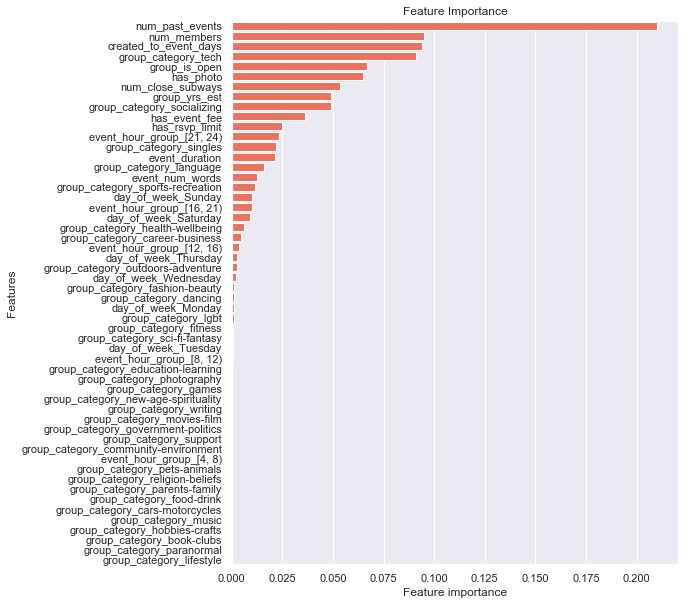

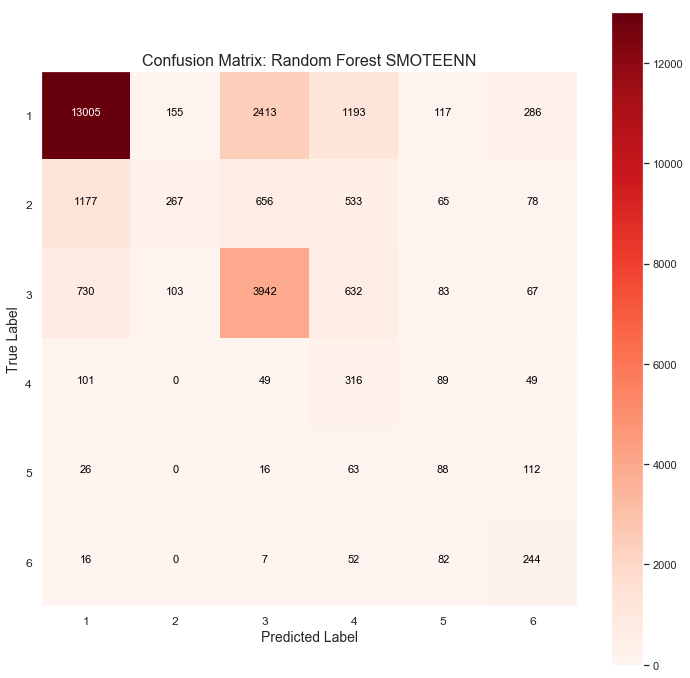

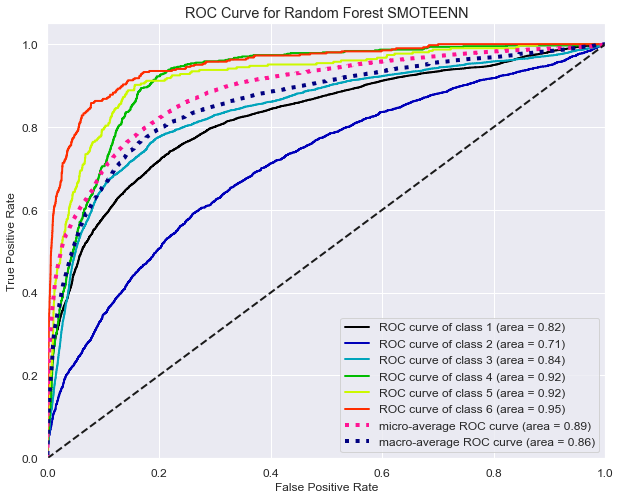

In [39]:
run_model(rf,
          pd.DataFrame(Xrf_train_resampled, columns =Xrf.columns), 
          Xrf_test, 
          yrf_train_resampled, 
          yrf_test, 
          'Random Forest SMOTEENN')

### Repeat with best parameters from gridsearch

A couple of different approaches:

1) Use gridsearch with `class_weight` parameter on the original, unsynthesized training data <br>
2) Use gridsearch on synthesized training data removing the class_weight parameter

#### 1) Use gridsearch with `class_weight` parameter on the original, unsynthesized training data <br>


In [15]:
# (1) gridsearch with class_weight
rfc = RandomForestClassifier(random_state=100)

param_grid = {
    "n_estimators": [100, 150, 200],
    "criterion": ["gini","entropy"],
    "max_depth": [5, 7],
    "min_samples_split": [2, 4],
    "oob_score": [True, False],
    "class_weight": ['balanced', 'balanced_subsample']
        }

gs_rf = GridSearchCV(rfc, param_grid, cv=3, n_jobs=4)

gs_rf.fit(Xrf_train, yrf_train)

print(gs_rf.best_params_)

{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 150, 'oob_score': True}



Classification Report
----------------------
              precision    recall  f1-score   support

           1       0.93      0.64      0.76     17169
           2       0.32      0.45      0.37      2776
           3       0.56      0.75      0.64      5557
           4       0.15      0.62      0.24       604
           5       0.24      0.37      0.29       305
           6       0.37      0.69      0.48       401

   micro avg       0.64      0.64      0.64     26812
   macro avg       0.43      0.59      0.46     26812
weighted avg       0.75      0.64      0.67     26812



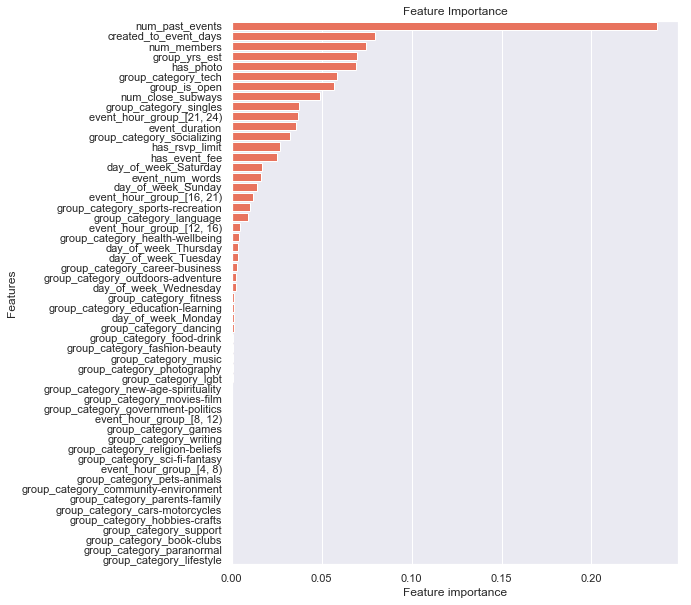

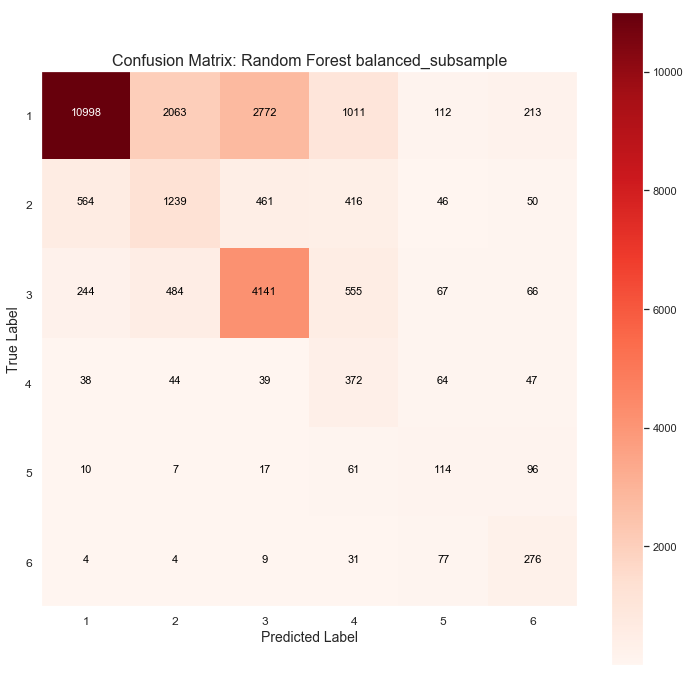

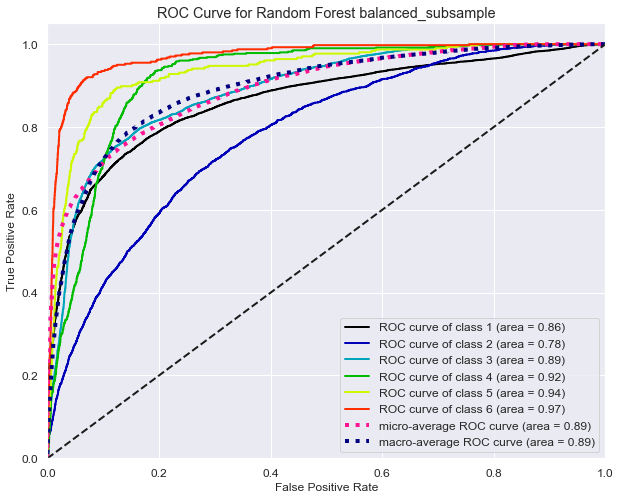

In [40]:
rfc_best = RandomForestClassifier(random_state=100, 
                                  n_estimators=150,
                                 class_weight='balanced_subsample',
                                 criterion='entropy',
                                 max_depth=7,
                                 min_samples_split=2,
                                 oob_score=True)

run_model(rfc_best, 
          pd.DataFrame(Xrf_train, columns=Xrf.columns), 
          Xrf_test, 
          yrf_train, 
          yrf_test, 
          'Random Forest balanced_subsample')

#### 2) Use gridsearch on synthesized training data

In [4]:
# gridsearch with SMOTE-ENN
%time

rfc2 = RandomForestClassifier(random_state=100, n_estimators = 200, oob_score=True)

param_grid = {
    "criterion": ['gini', 'entropy'],
    "max_depth": [5,7,9],
    "min_samples_split": [2,3,4]
        }

gs_rf_SMOTEENN = GridSearchCV(rfc2, param_grid, cv=3, n_jobs = 4)

gs_rf_SMOTEENN.fit(X_train_SMOTEEN, y_train_SMOTEEN)

print(gs_rf_SMOTEENN.best_params_)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 3}


In [41]:
# train model with best parameters
gs_rf_SMOTEENN_best = RandomForestClassifier(random_state=100, 
                                             n_estimators=200,
                                             criterion='entropy',
                                             max_depth=9,
                                             min_samples_split=3,
                                             oob_score=True)


Classification Report
----------------------
              precision    recall  f1-score   support

           1       0.89      0.79      0.84     17169
           2       0.49      0.33      0.40      2776
           3       0.65      0.75      0.70      5557
           4       0.18      0.65      0.29       604
           5       0.26      0.38      0.31       305
           6       0.40      0.69      0.50       401

   micro avg       0.73      0.73      0.73     26812
   macro avg       0.48      0.60      0.51     26812
weighted avg       0.77      0.73      0.74     26812



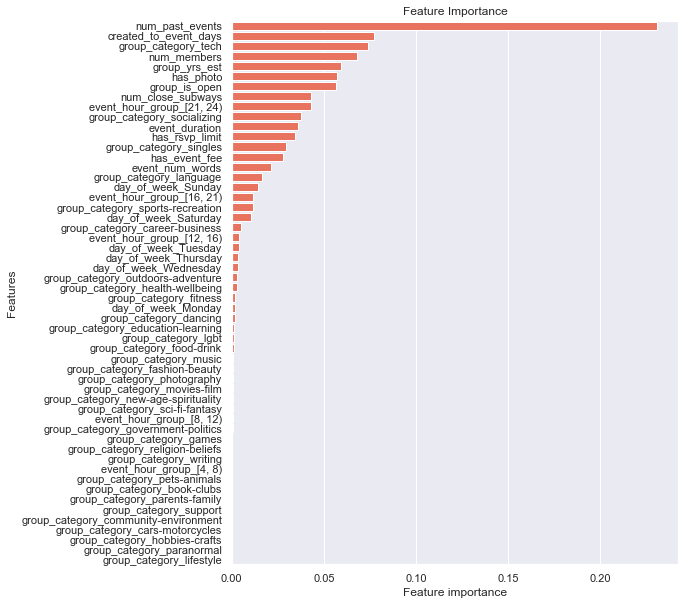

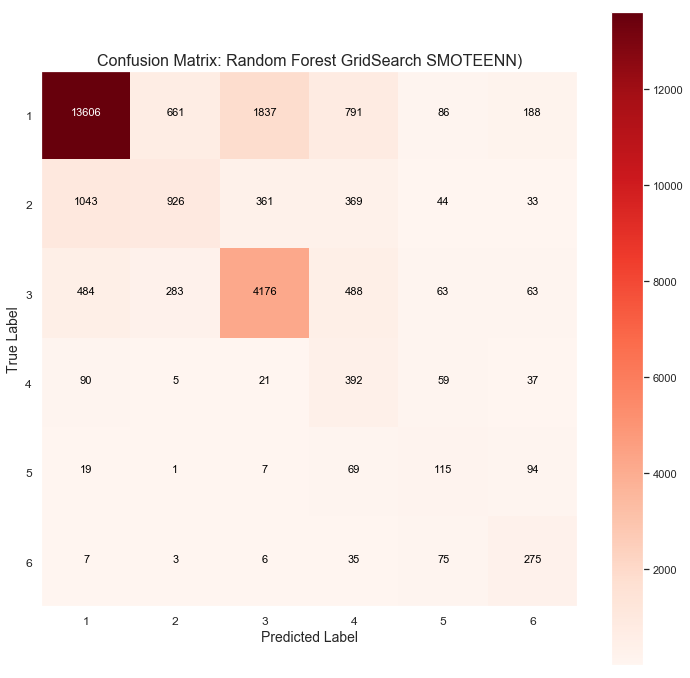

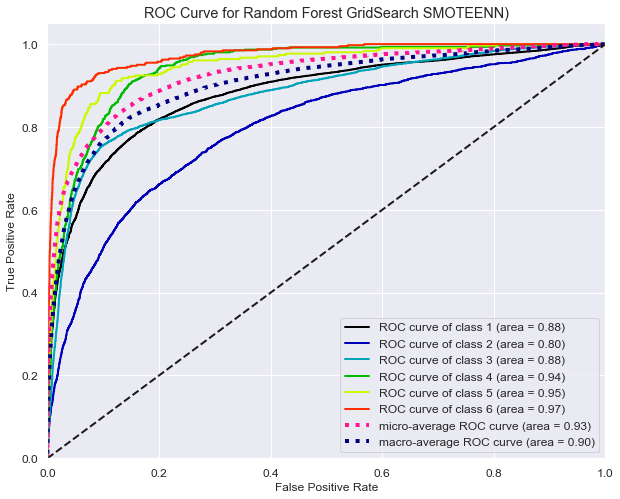

In [42]:
run_model(gs_rf_SMOTEENN_best, pd.DataFrame(X_train_SMOTEEN, columns=Xrf.columns), Xrf_test, y_train_SMOTEEN, yrf_test, 
          'Random Forest GridSearch SMOTEENN)')

***
<a id='boost'></a>

## 4. XGBoost Classifer

XGBoost (extreme gradient boosting) classifer is another ensemble model method.

#### Without SMOTEENN

In [74]:
with open('X_classification_v3.pickle', 'rb') as f:
    Xg= pickle.load(f)
    
with open('y_classification_v3.pickle', 'rb') as f:
    yg= pickle.load(f)

In [44]:
# have to replace '[' with '(' since it is an invalid character for xgboost model
Xg.rename(index=str, 
          columns={'event_hour_group_[4, 8)': 'event_hour_group_(4, 8)',
                  'event_hour_group_[8, 12)': 'event_hour_group_(8, 12)',
                  'event_hour_group_[12, 16)': 'event_hour_group_(12, 16)', 
                  'event_hour_group_[16, 21)': 'event_hour_group_(16, 21)',
                  'event_hour_group_[21, 24)':'event_hour_group_(21, 24)'}, 
         inplace=True)

In [75]:
Xg_train, Xg_test, yg_train, yg_test = train_test_split(normalize(Xg), yg, test_size=.2, random_state=100)


Classification Report
----------------------
              precision    recall  f1-score   support

           1       0.78      0.92      0.84     17169
           2       0.65      0.09      0.16      2776
           3       0.71      0.72      0.71      5557
           4       0.53      0.06      0.11       604
           5       0.53      0.06      0.10       305
           6       0.57      0.25      0.35       401

   micro avg       0.76      0.76      0.76     26812
   macro avg       0.63      0.35      0.38     26812
weighted avg       0.74      0.76      0.71     26812



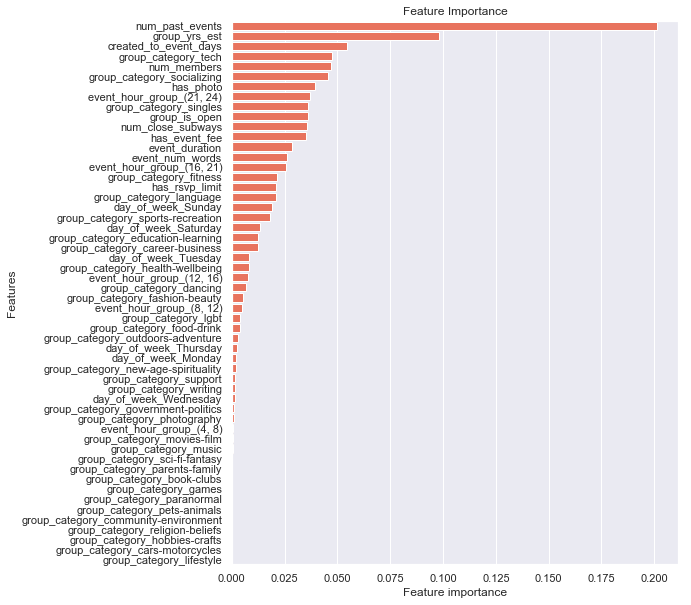

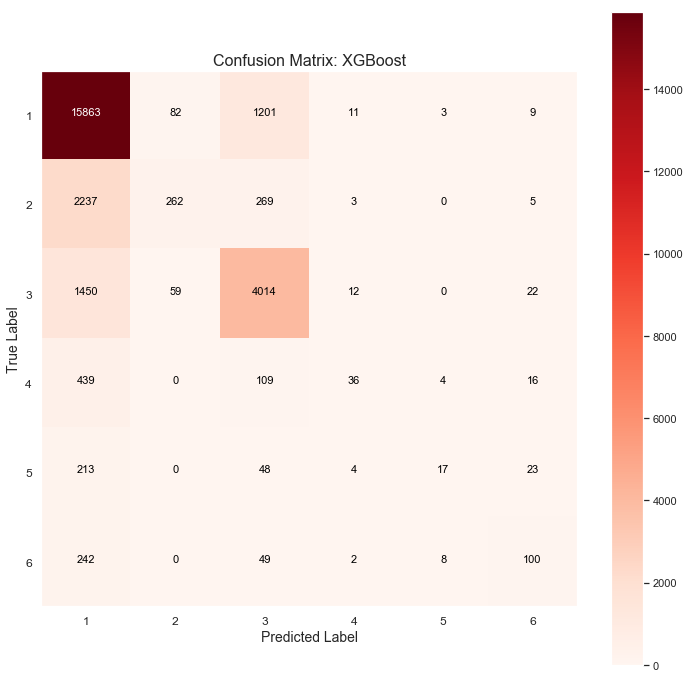

In [47]:
xgb = XGBClassifier(random_state=100, n_estimators=100)

run_model(xgb, 
          pd.DataFrame(Xg_train, columns=Xg.columns), 
          pd.DataFrame(Xg_test, columns=Xg.columns), 
          yg_train, 
          yg_test, 
          'XGBoost')

In [ ]:
# ROC graph
from itertools import cycle
    
classes = [1,2,3,4,5,6]

y_train_bin = label_binarize(yg_train, classes=classes)
y_test_bin = label_binarize(yg_test, classes=classes)

n_classes = len(classes)
classifier = OneVsRestClassifier(xgb)
y_score = classifier.fit(Xg_train, y_train_bin).predict_proba(Xg_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
                                                                 
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple'])
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.0])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for XGBoost Model')
plt.legend(loc="lower right")
plt.show()

#### With SMOTEENN

In [73]:
# open SMOTEEN X and y frames
with open('X_train_SMOTEEN.pickle', 'rb') as f:
    Xg_train_SMOTEEN = pickle.load(f)
    
with open('y_train_SMOTEEN.pickle', 'rb') as f:
    yg_train_SMOTEEN = pickle.load(f)

In [77]:
xgb_SMOTEEN = XGBClassifier(random_state=100, 
                             n_estimators=200, 
                             oob_score=True, 
                            learning_rate = 0.05,
                             n_jobs =2)


Classification Report
----------------------
              precision    recall  f1-score   support

           1       0.89      0.76      0.82     17169
           2       0.40      0.37      0.39      2776
           3       0.68      0.70      0.69      5557
           4       0.16      0.57      0.25       604
           5       0.19      0.43      0.27       305
           6       0.28      0.67      0.40       401

   micro avg       0.70      0.70      0.70     26812
   macro avg       0.43      0.58      0.47     26812
weighted avg       0.76      0.70      0.72     26812



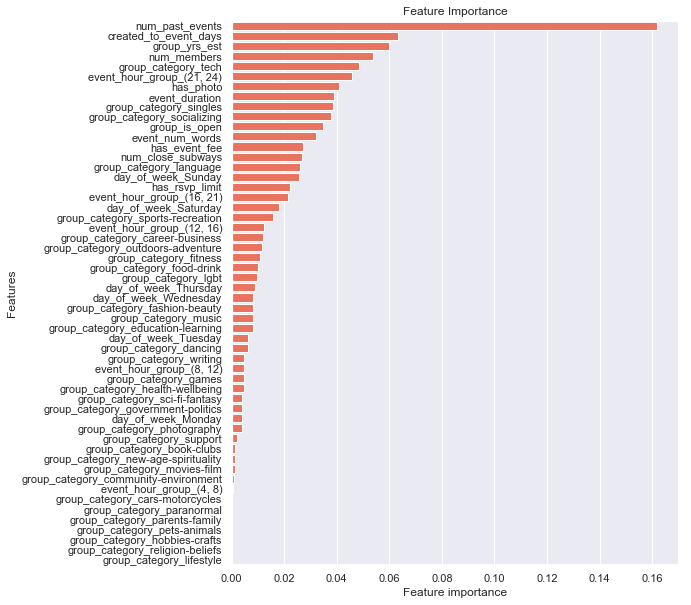

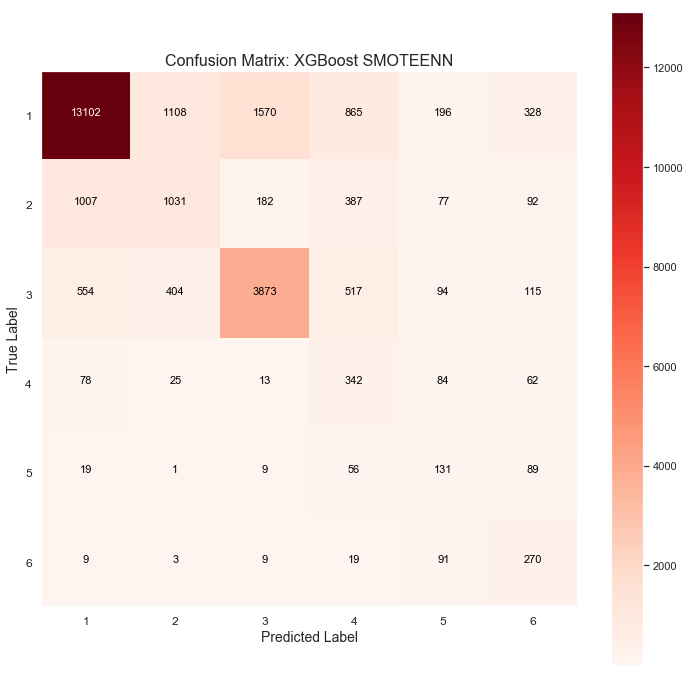

In [50]:
run_model(xgb_SMOTEEN,
          pd.DataFrame(Xg_train_SMOTEEN, columns=Xg.columns), 
          pd.DataFrame(Xg_test, columns=Xg.columns), 
          yg_train_SMOTEEN, 
          yg_test, 
          'XGBoost SMOTEENN')

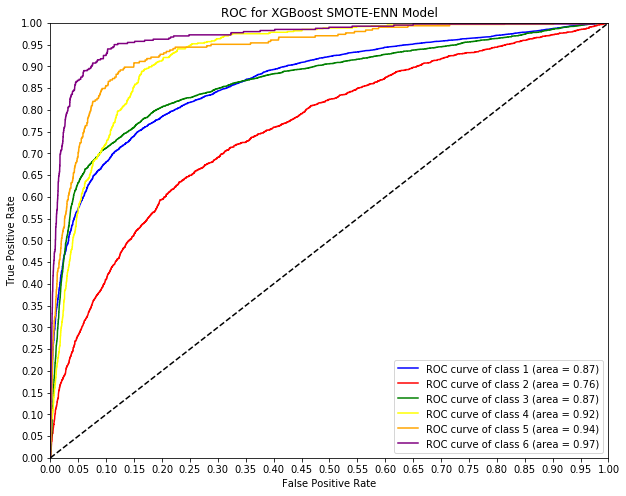

In [113]:
# ROC graph
from itertools import cycle
    
classes = [1,2,3,4,5,6]

y_train_bin = label_binarize(yg_train_SMOTEEN, classes=classes)
y_test_bin = label_binarize(yg_test, classes=classes)

n_classes = len(classes)
classifier = OneVsRestClassifier(xgb_SMOTEEN)
y_score = classifier.fit(Xg_train_SMOTEEN, y_train_bin).predict_proba(Xg_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
                                                                 
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple'])
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.0])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for XGBoost SMOTE-ENN Model')
plt.legend(loc="lower right")
plt.show()

***
<a id='svc'></a>
## 5. Penalized Support Vector Classifier

SVM Classifier did not perform well on this data. Model consistently predicted only 1 class across different kernels.

In [5]:
with open('X_classification_v3.pickle', 'rb') as f:
    Xv= pickle.load(f)
    
with open('y_classification_v3.pickle', 'rb') as f:
    yv= pickle.load(f)

In [6]:
Xv_train, Xv_test, yv_train, yv_test= train_test_split(normalize(Xv),yv,test_size=0.2,random_state=100)

In [22]:
svc = SVC(kernel='rbf', C=1.0, random_state=100)
svc.fit(Xv_train, yv_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=100,
  shrinking=True, tol=0.001, verbose=False)

In [23]:
svc_preds = svc.predict(Xv_test)

In [24]:
# print classification report
print('\nClassification Report')
print('----------------------')
print(classification_report(yv_test, svc_preds))


Classification Report
----------------------
              precision    recall  f1-score   support

           1       0.64      1.00      0.78     17169
           2       0.00      0.00      0.00      2776
           3       0.00      0.00      0.00      5557
           4       0.00      0.00      0.00       604
           5       0.00      0.00      0.00       305
           6       0.00      0.00      0.00       401

   micro avg       0.64      0.64      0.64     26812
   macro avg       0.11      0.17      0.13     26812
weighted avg       0.41      0.64      0.50     26812



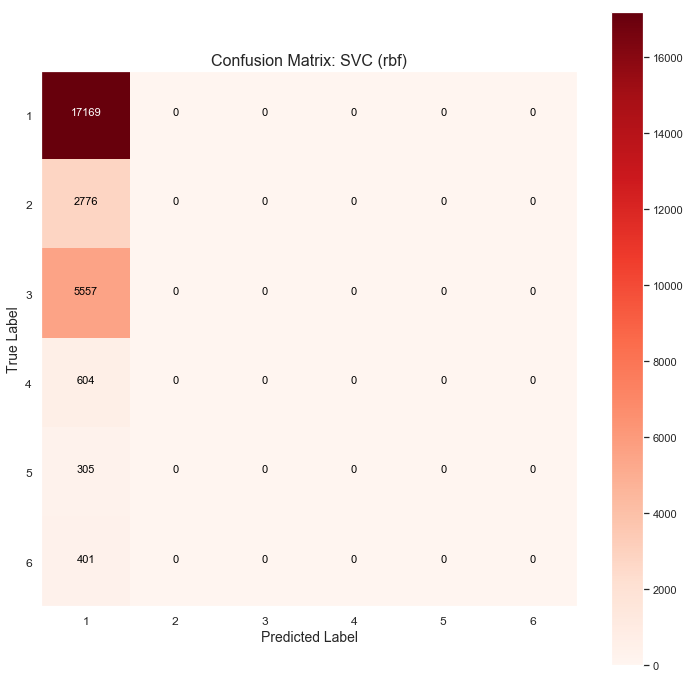

In [25]:
show_conf_matrix(yv_test, svc_preds, model_name='SVC (rbf)')

***
<a id='stacked'></a>
## 6. Aggregated Model

Take an average of the predictions made by 5 different tree-based models to get an aggregated prediction.

<u>Models:</u>
1. Decision Tree
2. Random Forest
3. Random Forest w/ SMOTE-ENN data
4. XGBoost
5. XGBoost w/ w/ SMOTE-ENN data

In [2]:
# with open('df_preds_2018_clasification.pickle', 'wb') as f:
#     pickle.dump(df_preds, f)
    
with open('df_preds_2018_clasification.pickle', 'rb') as f:
    df_preds= pickle.load(f)

In [51]:
all_preds = {'random_forest': rf.predict(Xrf_test).tolist(),
             'random_forest_SMOTEENN': rfc_best.predict(Xrf_test).tolist(),
            'xgboost': xgb.predict(pd.DataFrame(Xg_test, columns=Xg.columns)).tolist(),
             'xgboost_SMOTEENN': xgb_SMOTEEN.predict(pd.DataFrame(Xg_test, columns=Xg.columns)).tolist(),
            'decision_tree': tree_clf.predict(X_test).tolist()}

In [3]:
df_preds = pd.DataFrame(all_preds)

NameError: name 'all_preds' is not defined

In [4]:
df_preds.head()

,random_forest,random_forest_SMOTEENN,xgboost,xgboost_SMOTEENN,decision_tree,avg_vote
0,1,2,2,2,2,2.0
1,1,1,1,1,1,1.0
2,1,1,1,1,1,1.0
3,3,3,3,3,3,3.0
4,3,3,1,1,1,2.0


In [5]:
def get_all_votes(row):
    concat = str(row['random_forest'])+' '+str(row['random_forest_SMOTEENN'])+' '+str(row['xgboost'])+' '+str(row['xgboost_SMOTEENN'])+' '+str(row['decision_tree'])
    return concat.split()

In [7]:
df_preds['all_votes'] = df_preds.apply(get_all_votes, axis=1)

In [8]:
df_preds.head()

,random_forest,random_forest_SMOTEENN,xgboost,xgboost_SMOTEENN,decision_tree,avg_vote,all_votes
0,1,2,2,2,2,2.0,"[1.0, 2.0, 2.0, 2.0, 2.0]"
1,1,1,1,1,1,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0]"
2,1,1,1,1,1,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0]"
3,3,3,3,3,3,3.0,"[3.0, 3.0, 3.0, 3.0, 3.0]"
4,3,3,1,1,1,2.0,"[3.0, 3.0, 1.0, 1.0, 1.0]"


In [65]:
def get_aggregated_vote(row):
'''
apply this function to dataframe on axis=1 to iterate through dataframe rows
'''
    # get the median
    median = sorted([float(n) for n in row['all_votes']])[2]
    
    # create a dictionary to keep track of votes per label
    dict_ = {}
    for s in row['all_votes']:
        if s not in dict_:
            dict_[s] = 1
        else:
            dict_[s] += 1
    # get count of unique votes and double votes
    unique_counter = 0
    doubles_counter = 0
    for k, v in dict_.items():
        if v == 1:
            unique_counter +=1
        if v == 2:
            doubles_counter +=1
    # return median in a tie, else the label w/ most votes
    if unique_counter == 5 or doubles_counter ==2:
        return median
    else:   
        return max(dict_, key=dict_.get)

In [56]:
df_preds['aggregated_vote']= df_preds.apply(get_aggregated_vote, axis=1)

In [48]:
df_preds['aggregated_vote'] = df_preds['aggregated_vote'].astype(float)

In [59]:
df_preds.drop(labels=['avg_vote'], axis=1, inplace=True)

In [61]:
pd.set_option('display.max_columns', None)
df_preds.head()

,random_forest,random_forest_SMOTEENN,xgboost,xgboost_SMOTEENN,decision_tree,all_votes,final_vote_median
0,1,2,2,2,2,"[1.0, 2.0, 2.0, 2.0, 2.0]",2.0
1,1,1,1,1,1,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.0
2,1,1,1,1,1,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.0
3,3,3,3,3,3,"[3.0, 3.0, 3.0, 3.0, 3.0]",3.0
4,3,3,1,1,1,"[3.0, 3.0, 1.0, 1.0, 1.0]",1.0


In [70]:
# MEDIAN
print('\nClassification Report')
print('----------------------')
print(classification_report(y_test, df_preds['aggregated_vote']))


Classification Report
----------------------
              precision    recall  f1-score   support

           1       0.86      0.81      0.83     17169
           2       0.44      0.30      0.36      2776
           3       0.67      0.73      0.70      5557
           4       0.17      0.53      0.26       604
           5       0.26      0.41      0.32       305
           6       0.45      0.58      0.51       401

   micro avg       0.72      0.72      0.72     26812
   macro avg       0.48      0.56      0.50     26812
weighted avg       0.75      0.72      0.73     26812



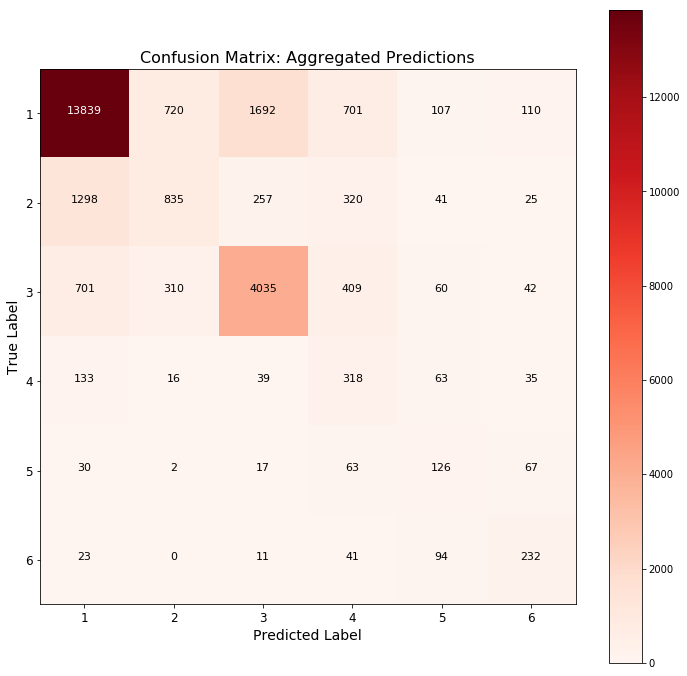

In [69]:
show_conf_matrix(y_test, df_preds['aggregated_vote'], model_name='Aggregated Predictions')